In [1]:
#Importing dependencies

import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2) 
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/google.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,1.4375,1.5625,1.3125,1.4375,1.301192,26600
1,2001-01-03,1.4375,1.4375,1.4375,1.4375,1.301192,18300
2,2001-01-04,1.3125,1.5625,1.3125,1.5000,1.357766,17700
3,2001-01-05,1.5000,1.6875,1.5000,1.6875,1.527486,13000
4,2001-01-08,1.6875,2.0000,1.6875,2.0000,1.810354,60200


In [4]:
df.shape

(5042, 7)

In [5]:
df['Date']= pd.to_datetime(df['Date'])


In [6]:
df.set_index("Date",inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-11,33.250000,33.910000,33.000000,33.119999,33.119999,78600
2021-01-12,33.369999,33.720001,33.000000,33.240002,33.240002,82100
2021-01-13,33.130001,33.410000,32.830002,33.349998,33.349998,76100
2021-01-14,33.619999,34.070000,33.450001,33.939999,33.939999,90700
2021-01-15,33.689999,34.099998,33.169998,33.619999,33.619999,60100


In [7]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    5.042000e+03
mean     7.190071e+04
std      8.492364e+04
min      0.000000e+00
25%      2.400000e+04
50%      4.980000e+04
75%      9.097500e+04
max      2.073400e+06
Name: Volume, dtype: float64


In [8]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [9]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
    print(X_train.shape,Y_train.shape,train.shape[0],Y_train[0])

    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    print(X_val.shape,Y_val.shape)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [10]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [11]:
# plotting the prediction
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [12]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [13]:
# Extracting the series
series = df[['Close','High','Volume']] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(5040, 3)
                Close       High  Volume
Date                                    
2021-01-11  33.119999  33.910000   78600
2021-01-12  33.240002  33.720001   82100
2021-01-13  33.349998  33.410000   76100
2021-01-14  33.939999  34.070000   90700
2021-01-15  33.619999  34.099998   60100


In [19]:
train_start = dt.date(2001,1,2)
train_end = dt.date(2016,12,31)
train_data = series.loc[train_start:train_end]


val_start = dt.date(2017,1,1)
val_end = dt.date(2019,12,31)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2020,1,1)
test_end = dt.date(2021,1,15)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(4023, 3) (754, 3) (263, 3)


In [21]:
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,test.shape)

(4023, 3) (263, 3)


In [17]:
timesteps = 10
hl = [45,30]
lr = 1e-3
batch_size = 150
num_epochs = 250

(4013, 10, 3) (4013,) 4023 0.035065406976744186
(744, 10, 3) (744,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 3)             84        
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 45)            8820      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                9120      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 18,055
Trainable params: 18,055
Non-trainable params: 0
_________________________________________________________________
None


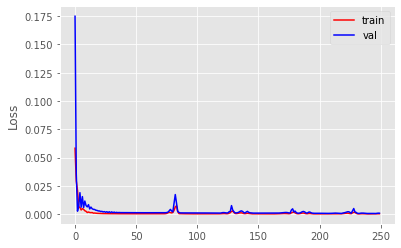

In [23]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

(253, 10, 3) (253,)
MSE = 0.0019791359369559147
RMSE = 0.04448748067665683
R-Squared Score = 0.9416110228906518


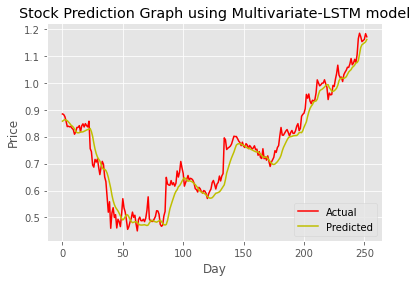

In [24]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
#Save a model
fname = 'MV3-LSTM_10_[45,30]_1e-3_150.h5'

model.save_weights(fname,overwrite=True)
# Load a model
 model = load_model('MV3-LSTM_10_[45,30]_1e-3_100.h5')

In [29]:
model_json = model.to_json()

In [31]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [32]:
!pip install pyyaml h5py

In [35]:
import os

In [43]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1610793276.h5


In [44]:
!ls

 1610793276.h5	 model.h5    'MV3-LSTM_10_[45,30]_1e-3_150.h5'	 sample_data
 drive		 model.json  'MV3-LSTM_30_[45,30]_1e-3_150.h5'
